In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [3]:
vsibench = load_dataset("nyu-visionx/VSI-Bench")
df = vsibench["test"].to_pandas()

In [5]:
qdf = df[df["question_type"] == "object_counting"].copy()
qdf["question"].sample(3).values

array(['How many chair(s) are in this room?',
       'How many monitor(s) are in this room?',
       'How many bed(s) are in this room?'], dtype=object)

In [35]:
qdf['ground_truth_str'] = qdf['ground_truth'].astype(str)
qdf["ground_truth"] =  qdf["ground_truth"].astype(int)
qdf['object'] = qdf['question'].str.extract(r'How many (.*?)\(s\) are in this room')[0].str.strip()

In [48]:
# --- Calculate Frequencies ---
obj_counts = qdf['object'].value_counts().reset_index()
# obj_counts /= obj_counts.sum()  # Normalize to frequency
obj_counts.columns = ['object', 'obj_count']
combo_counts = qdf.groupby(['object', 'ground_truth']).size().reset_index(name='combo_count')

# --- Merge Frequencies ---
df_merged = pd.merge(qdf, obj_counts, on='object', how='left')
df_merged = pd.merge(df_merged, combo_counts, on=['object', 'ground_truth'], how='left')

# Fill potential NaNs in counts with 0 if a object/gt/combo only appeared once etc.
df_merged.fillna({'obj_count': 0, 'combo_count': 0}, inplace=True)

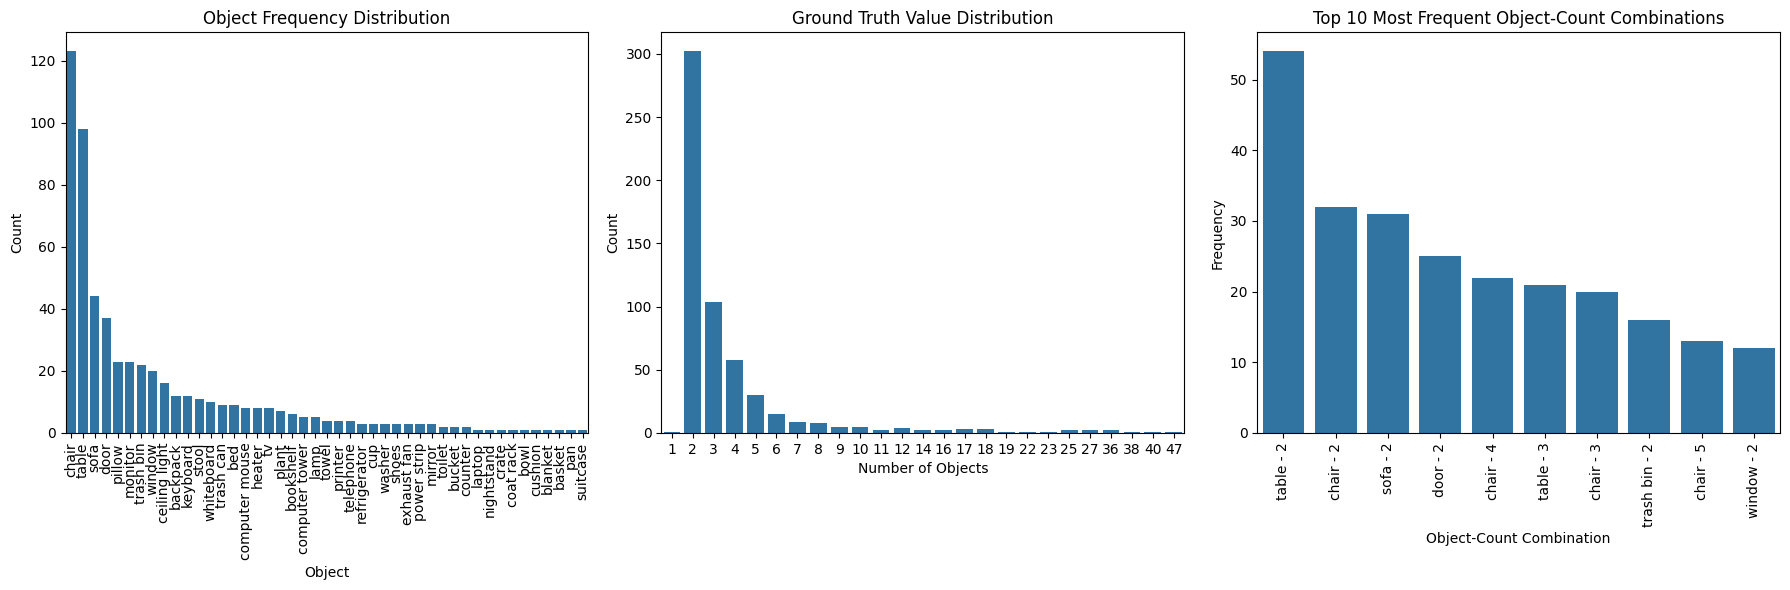

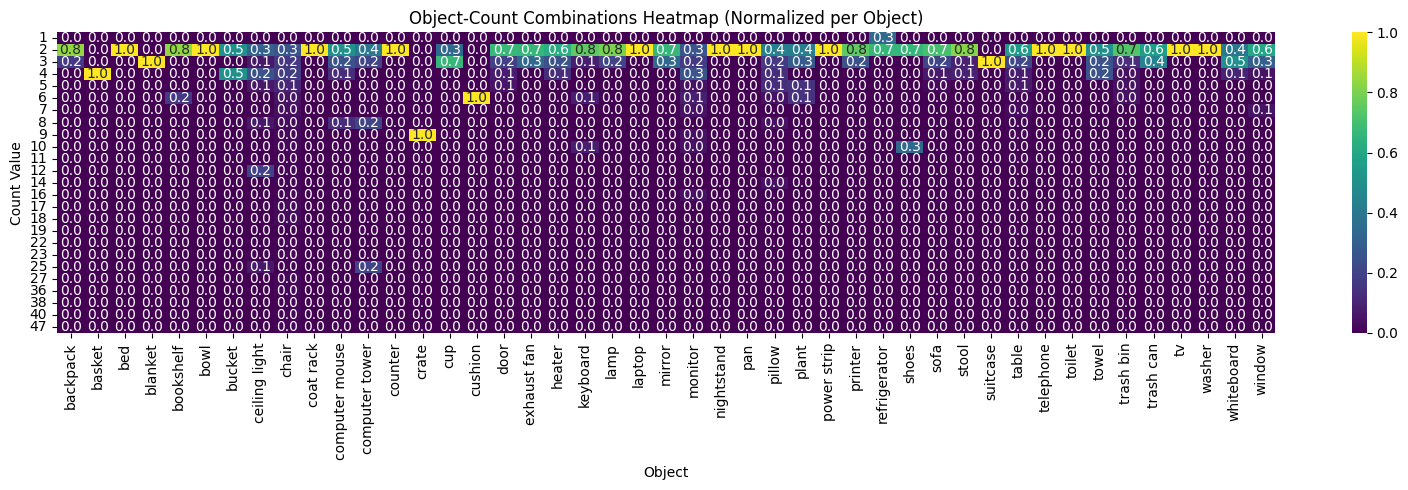

In [ ]:
# visualize the distributions
# Create two separate figures - one for the heatmap and one for the bar plots

# Figure 1: Bar plots in a 1x3 layout
fig_bars, axes_bars = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Object frequency distribution
sns.barplot(x='object', y='obj_count', data=obj_counts.sort_values('obj_count', ascending=False), ax=axes_bars[0])
axes_bars[0].set_title('Object Frequency Distribution')
axes_bars[0].set_xlabel('Object')
axes_bars[0].set_ylabel('Count')
axes_bars[0].tick_params(axis='x', rotation=90)

# Plot 2: Ground truth value distribution
gt_counts = qdf['ground_truth'].value_counts().reset_index()
gt_counts.columns = ['ground_truth', 'count']
sns.barplot(x='ground_truth', y='count', data=gt_counts.sort_values('ground_truth'), ax=axes_bars[1])
axes_bars[1].set_title('Ground Truth Value Distribution')
axes_bars[1].set_xlabel('Number of Objects')
axes_bars[1].set_ylabel('Count')

# Plot 3: Top 10 most frequent object-count combinations
top_combos = combo_counts.sort_values('combo_count', ascending=False).head(10)
top_combos['combo'] = top_combos['object'] + ' - ' + top_combos['ground_truth'].astype(str)
sns.barplot(x='combo', y='combo_count', data=top_combos, ax=axes_bars[2])
axes_bars[2].set_title('Top 10 Most Frequent Object-Count Combinations')
axes_bars[2].set_xlabel('Object-Count Combination')
axes_bars[2].set_ylabel('Frequency')
axes_bars[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Figure 2: Heatmap in its own wide plot
fig_heatmap, ax_heatmap = plt.subplots(figsize=(16, 5))

# Create heatmap of object and ground truth combinations
combo_pivot = pd.pivot_table(
    combo_counts, 
    values='combo_count', 
    index='ground_truth', 
    columns='object', 
    fill_value=0
)
# Sort the index (ground truth values) numerically
# Convert index to numeric type first to ensure proper sorting
combo_pivot.index = pd.to_numeric(combo_pivot.index)

# Normalize values per column (each object)
# combo_pivot_normalized = combo_pivot.apply(lambda x: x / x.sum() if x.sum() > 0 else x, axis=0)
combo_pivot_normalized = combo_pivot.apply(lambda x: x / x.sum() if x.sum() > 0 else x, axis=0)

# Use percentage format for normalized values
sns.heatmap(combo_pivot_normalized, annot=True, cmap='viridis', fmt='.1f', ax=ax_heatmap)
ax_heatmap.set_title('Object-Count Combinations Heatmap (Normalized per Object)')
ax_heatmap.set_xlabel('Object')
ax_heatmap.set_ylabel('Count Value')


plt.tight_layout()
plt.show()


In [50]:
df_merged.head()

,id,dataset,scene_name,question_type,question,ground_truth,options,ground_truth_str,object,obj_count,combo_count
0,0,arkitscenes,41069025,object_counting,How many table(s) are in this room?,4,None,4,table,98,8
1,1,arkitscenes,41069025,object_counting,How many chair(s) are in this room?,2,None,2,chair,123,32
2,2,arkitscenes,41069043,object_counting,How many table(s) are in this room?,2,None,2,table,98,54
3,3,arkitscenes,41125700,object_counting,How many sofa(s) are in this room?,2,None,2,sofa,44,31
4,4,arkitscenes,41125700,object_counting,How many table(s) are in this room?,3,None,3,table,98,21


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder


feature_cols = [
    'object',
    'obj_count',
    'combo_count',
]
target_col = "ground_truth"

def evaluate_rf_bias_cv_regression(df: pd.DataFrame, n_splits: int = 5, feature_cols=feature_cols, target_col=target_col) -> tuple[float, float, pd.DataFrame]:
    """
    Trains and evaluates a RandomForestRegressor using k-fold cross-validation
    on non-visual features of object_rel_distance questions to predict the
    ground truth answer (numerical regression).

    Args:
        df
        n_splits: Number of folds for KFold cross-validation.

    Returns:
        A tuple containing:
        - mean_mse (float): Mean MSE across the cross-validation folds.
        - std_mse (float): Standard deviation of MSE across the folds.
        - feature_importance_df (pd.DataFrame | None): DataFrame with feature importances
        from a model trained on the full dataset, or None if calculation fails.
    """
    print(f"--- Starting RF Bias Evaluation (Regression CV with {n_splits} splits) ---")

    # Check for essential columns
    required_cols = feature_cols + [target_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Input DataFrame is missing required columns: {missing_cols}")
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Create a working copy and drop rows with missing values in relevant columns
    data = df[required_cols].copy()
    initial_rows = len(data)
    data.dropna(inplace=True)
    final_rows = len(data)
    if final_rows < initial_rows:
        print(f"Warning: Dropped {initial_rows - final_rows} rows due to missing values in features or target.")

    if data.empty:
        print("Error: DataFrame is empty after dropping NA. Cannot proceed.")
        raise ValueError("DataFrame is empty after dropping NA.")

    X = data[feature_cols]
    y = data[target_col]

    print(f"Using {len(X)} samples for evaluation.")

    # --- 2. Preprocess Features ---
    encoders = {}
    X_encoded = X.copy()
    categorical_cols = X.select_dtypes(include='object').columns

    if not categorical_cols.empty:
        print(f"Encoding categorical features: {list(categorical_cols)}")
        for col in categorical_cols:
            encoders[col] = LabelEncoder()
            # Fit on the entire column before cross-validation
            X_encoded[col] = encoders[col].fit_transform(X_encoded[col].astype(str))
    else:
        print("No categorical features found to encode.")

    # --- 3. Define Model and Cross-Validation Strategy ---
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- 4. Perform Cross-Validation ---
    print(f"Performing {n_splits}-Fold Cross-Validation...")
    try:
        # Use cross_val_score to get MSE for each fold
        scores = cross_val_score(model, X_encoded, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        mean_mse = -np.mean(scores)  # Convert negative MSE to positive
        std_mse = np.std(scores)
        print(f"Scores for each fold (negative MSE): {scores}")
        print(f"Mean MSE: {mean_mse:.4f}")
        print(f"Standard Deviation of MSE: {std_mse:.4f}")
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        return np.nan, np.nan, None  # Return NaN if CV fails

    # --- 5. Train Final Model and Get Feature Importances ---
    feature_importance_df = None  # Initialize as None
    print("\nTraining final model on all data to get feature importances...")
    try:
        final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        final_model.fit(X_encoded, y)
        importances = final_model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X_encoded.columns, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
        print("\nFeature Importances (from final model trained on all data):")
        print(feature_importance_df)
    except Exception as e:
        print(f"Could not calculate feature importances: {e}")

    print("--- Evaluation Complete ---")
    return mean_mse, std_mse, feature_importance_df


evaluate_rf_bias_cv_regression(df_merged, n_splits=30);

--- Starting RF Bias Evaluation (Regression CV with 30 splits) ---
Using 565 samples for evaluation.
Encoding categorical features: ['object']
Performing 30-Fold Cross-Validation...
Scores for each fold (negative MSE): [ -0.26276451  -9.26883395  -2.77039094  -6.98670983 -11.55953241
  -1.90472655 -12.72714161 -21.3199493   -1.37926316 -24.00116932
 -19.34033705  -0.191377   -20.72685336  -8.8346604  -10.57474102
  -0.4674675   -1.54586905  -0.48799652  -0.33044807  -0.31867429
 -12.40943453  -7.17837271  -0.10630964 -10.98563213  -3.7407702
 -25.87729071 -21.58333337 -45.32643569  -3.39187273  -0.1834705 ]
Mean MSE: 9.5261
Standard Deviation of MSE: 10.4724

Training final model on all data to get feature importances...

Feature Importances (from final model trained on all data):
       feature  importance
0    obj_count    0.570301
1  combo_count    0.383222
2       object    0.046477
--- Evaluation Complete ---
